# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [82]:
# import libraries
import re
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, recall_score
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm


%matplotlib inline
%config InlineBackend.figure_format='retina'

In [83]:
# Define Plot Color
blue = sns.color_palette()[0]
# Plot Style
plt.style.use('seaborn')
# Define Matplotlib Params
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (12, 9)
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['figure.titlesize'] = 'xx-large' 
mpl.rcParams['axes.titlesize'] = 'large' 

mpl.rcParams['axes.titley'] = 1.03 

In [84]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /Users/florian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/florian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/florian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/florian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [85]:

def create_metric_dataframe(y_test, y_pred, labels):
    '''
    INPUT:
            Test labels dataframe: y_test, 
            Prediction dataframe: y_pred,
            Array of labels: labels
    OUTPUT: 
            Dataframe with index column, metric, ,etric_value, label
            index: True positive, or True negative
            metric: accuracy, precision, recall, fscore
            metric_value: the value for the specific metric
            label: the label for the prediction
    WHAT ITS DO:
            Use precision_recall_fscore and accuracy_score functions from sklearn.metrics
            Combine the metrics to a large metric dataframe
    '''
    
    ## Initiate an empty data frame with predefined columns
    ## The column index contains 0 or 1 because the precision recall fscore metrics are calculated 
    ## For true positive and true negative
    metric_complete = pd.DataFrame(columns=['index', 'metric', 'metric_value', 'label'])

    ## Loop over all labes an call the precision_recall_fscore method for each label
    for label in labels:
        metric = precision_recall_fscore_support(y_test.loc[:,label], y_pred.loc[:,label], zero_division=0)
        accuracy = accuracy_score(y_test.loc[:,label], y_pred.loc[:,label])
        ## Create a dataframe from label metric
        metric_df = pd.DataFrame({'precision': metric[0], 'recall': metric[1], 'fscore': metric[2], 'accuracy': accuracy})
        ## Melt the dataframe
        metric_df = metric_df.reset_index().melt(id_vars='index', var_name='metric', value_name='metric_value')
        ## Add Label column
        metric_df['label'] = label
        ## Concat each label dataframe with complete dataframe
        metric_complete = pd.concat([metric_complete, metric_df])


        metric_complete.sort_values(by=['metric_value'], ascending=False, inplace=True)
    
    return metric_complete

In [86]:
def create_metric_mean(metric_complete, index, order):
    '''
    INPUT: 
            metric dataframe: Dataframe with different 
            metrics in metric column and metric_value column
    OUTPUT: mean_value dataframe and the mean values itself in given order
    '''
    metric_means = metric_complete.groupby(['index','metric']).metric_value.mean().reset_index()

    mean_values_df = metric_means.query('index==@index')[['metric', 'metric_value']]
    mean_values_df.set_index('metric', inplace=True)
    mean_values_df = mean_values_df.reindex(order)
    mean_values = mean_values_df.metric_value.values
    
    return mean_values_df, mean_values

    

In [87]:
# load data from database
engine = create_engine('sqlite:///../data/DisasterResponse.db')
df = pd.read_sql_table('labeled_messages', engine)
X = df.iloc[:,1]
y = df.iloc[:,4:]

In [88]:
## Extract the disaster labels
labels = list(y.columns)

In [164]:
## Check which text messages have assigned labels
disasters_assigned = pd.DataFrame(y.sum(axis=1).value_counts()).reset_index()
disasters_assigned.columns = ['messages_assigned', 'message_count']

In [165]:
disasters_assigned

,messages_assigned,message_count
0,0,6310
1,1,5121
2,3,3609
3,5,2956
4,4,2276
5,6,1903
6,7,1347
7,8,880
8,9,577
9,2,443


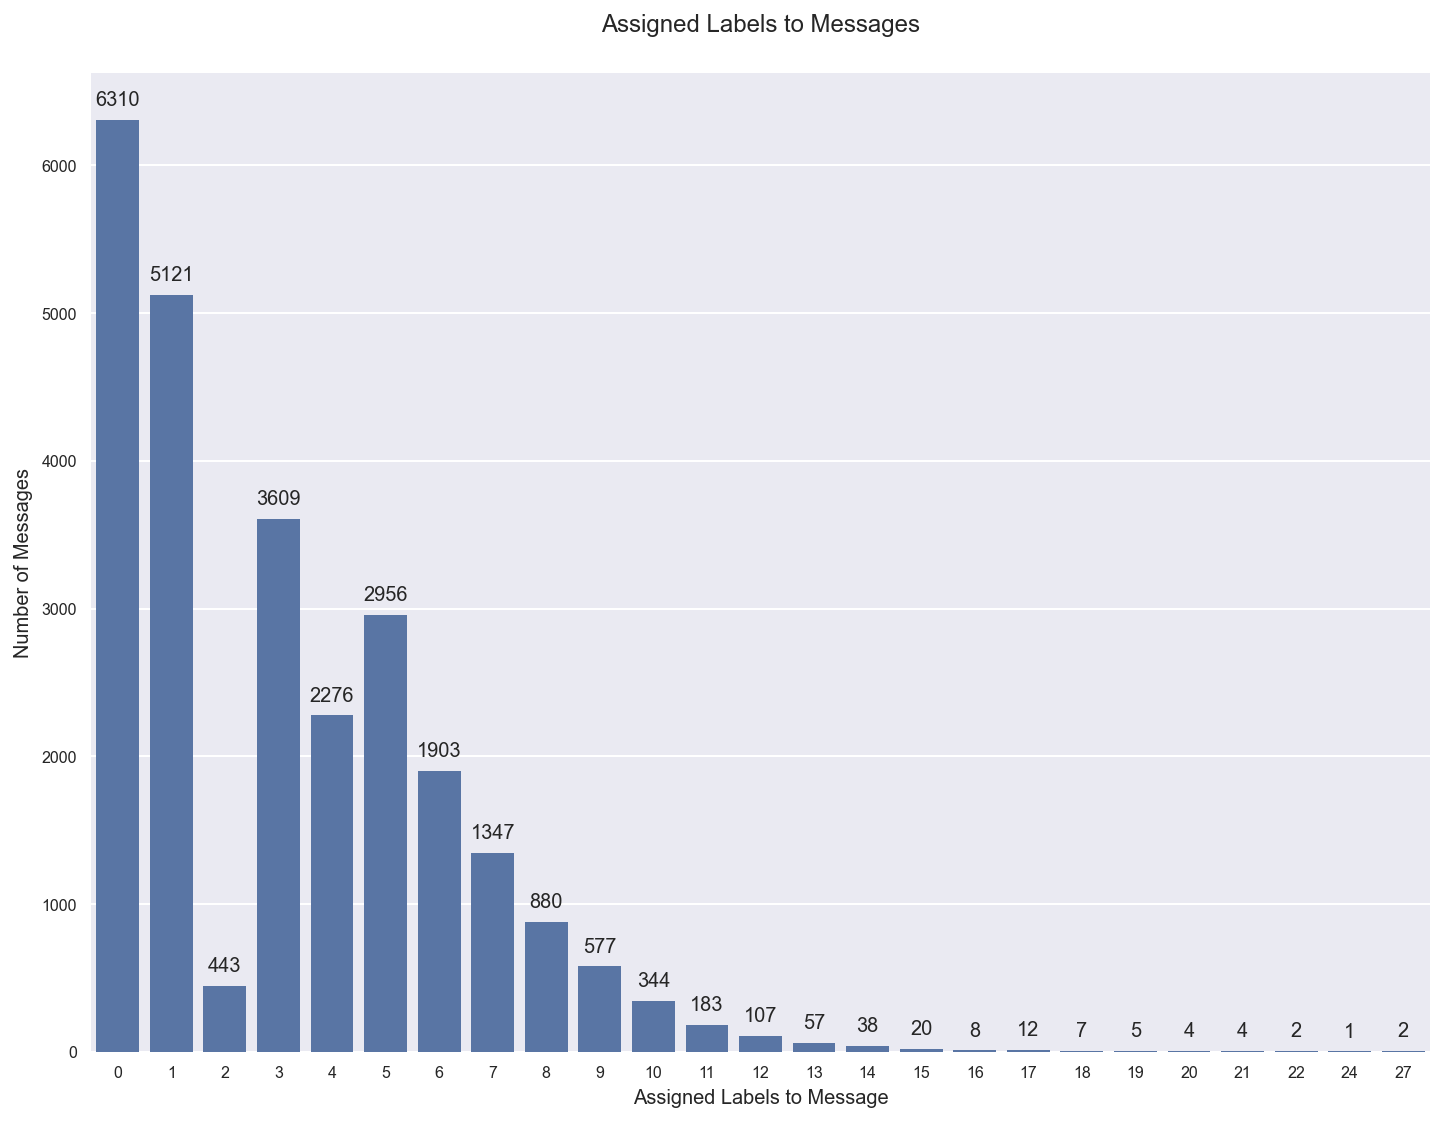

In [168]:

ax = sns.barplot(data=disasters_assigned, x='messages_assigned', y='message_count',color=blue)
plt.title('Assigned Labels to Messages')
plt.xlabel('Assigned Labels to Message')
plt.ylabel('Number of Messages')

for p in ax.patches:
    text = '{}'.format(int(p.get_height()))
    xy = (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height())
    ax.annotate(text, xy, ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')



Most disaster messages are labeled without any label. Additional there are arount 5000 messages which have only the label related. 

In [91]:
y.sum().sort_values().head()

child_alone      0
offer          118
shops          120
tools          159
fire           282
dtype: int64

For the category **child_alone** are no messages available. I will drop this category because it is not possible to train a model without any data.<br>
Additional to this, there are many categories with little messages.

In [92]:
y = y.drop('child_alone', axis=1)
## Get list of the categorie names
labels=y.columns


### 2. Write a tokenization function to process your text data

In [93]:
def tokenize(text):
    # Step 1 Normalisation
    text = re.sub(r'[^A-Za-z0-9]', ' ', text.lower())
    
    # Step 2 Tokenzation
    words = word_tokenize(text)
    
    #Step 3 Lemmatization
    tokens = [WordNetLemmatizer().lemmatize(word=w) for w in words]
    
    return tokens

In [94]:
metric_order = ['accuracy', 'precision', 'recall', 'fscore']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [15]:
pipeline_1 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

#### Split the data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [41]:
%%time
pipeline_1.fit(X_train, y_train)

CPU times: user 4min 1s, sys: 1.03 s, total: 4min 2s
Wall time: 4min 2s


Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7f7ee80328b0>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [43]:
%%time
## Create a prediction Dataframe on the test data
y_pred_1 = pd.DataFrame((pipeline_1.predict(X_test)), columns=y_test.columns)

CPU times: user 14.1 s, sys: 242 ms, total: 14.3 s
Wall time: 14.4 s


#### Create metric Dataframe

In [44]:
metric_complete_1 = create_metric_dataframe(y_test, y_pred_1, labels)

**Metric mean value summary**

In [45]:
metric_means_1, mean_values_1 = create_metric_mean(metric_complete_1, 1, metric_order)

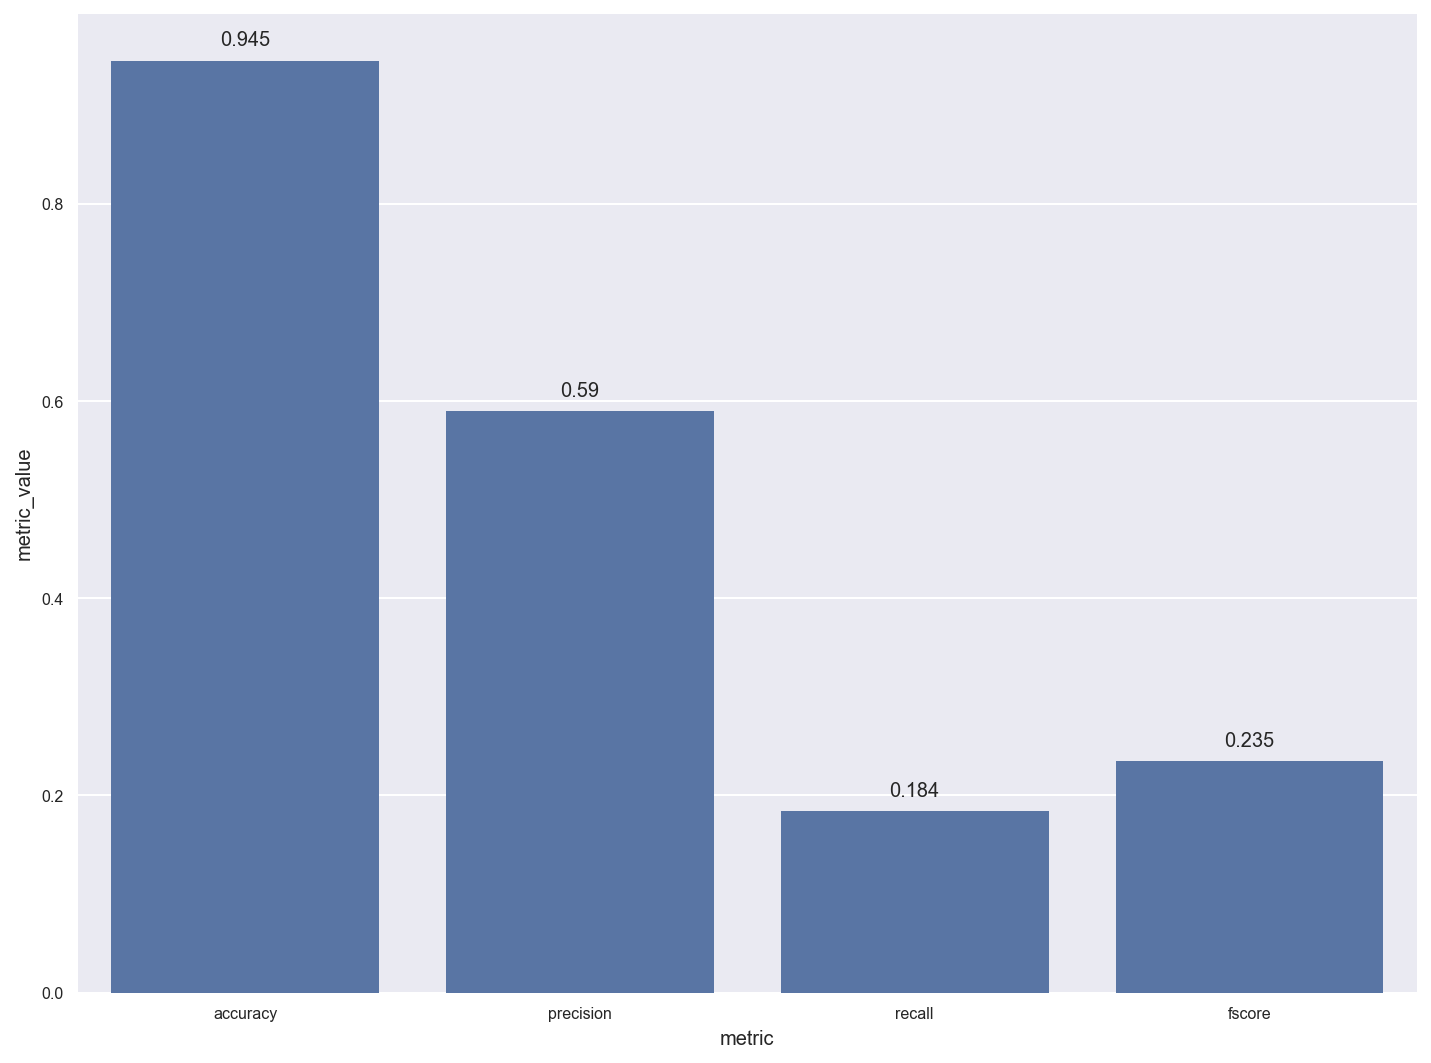

In [49]:
ax = sns.barplot(data=metric_means_1.reset_index(), x='metric', y='metric_value', order=metric_order, color=blue)

for p in ax.patches:
    text = '{}'.format(round(p.get_height(),3))
    xy = (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height())
    ax.annotate(text, xy, ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')



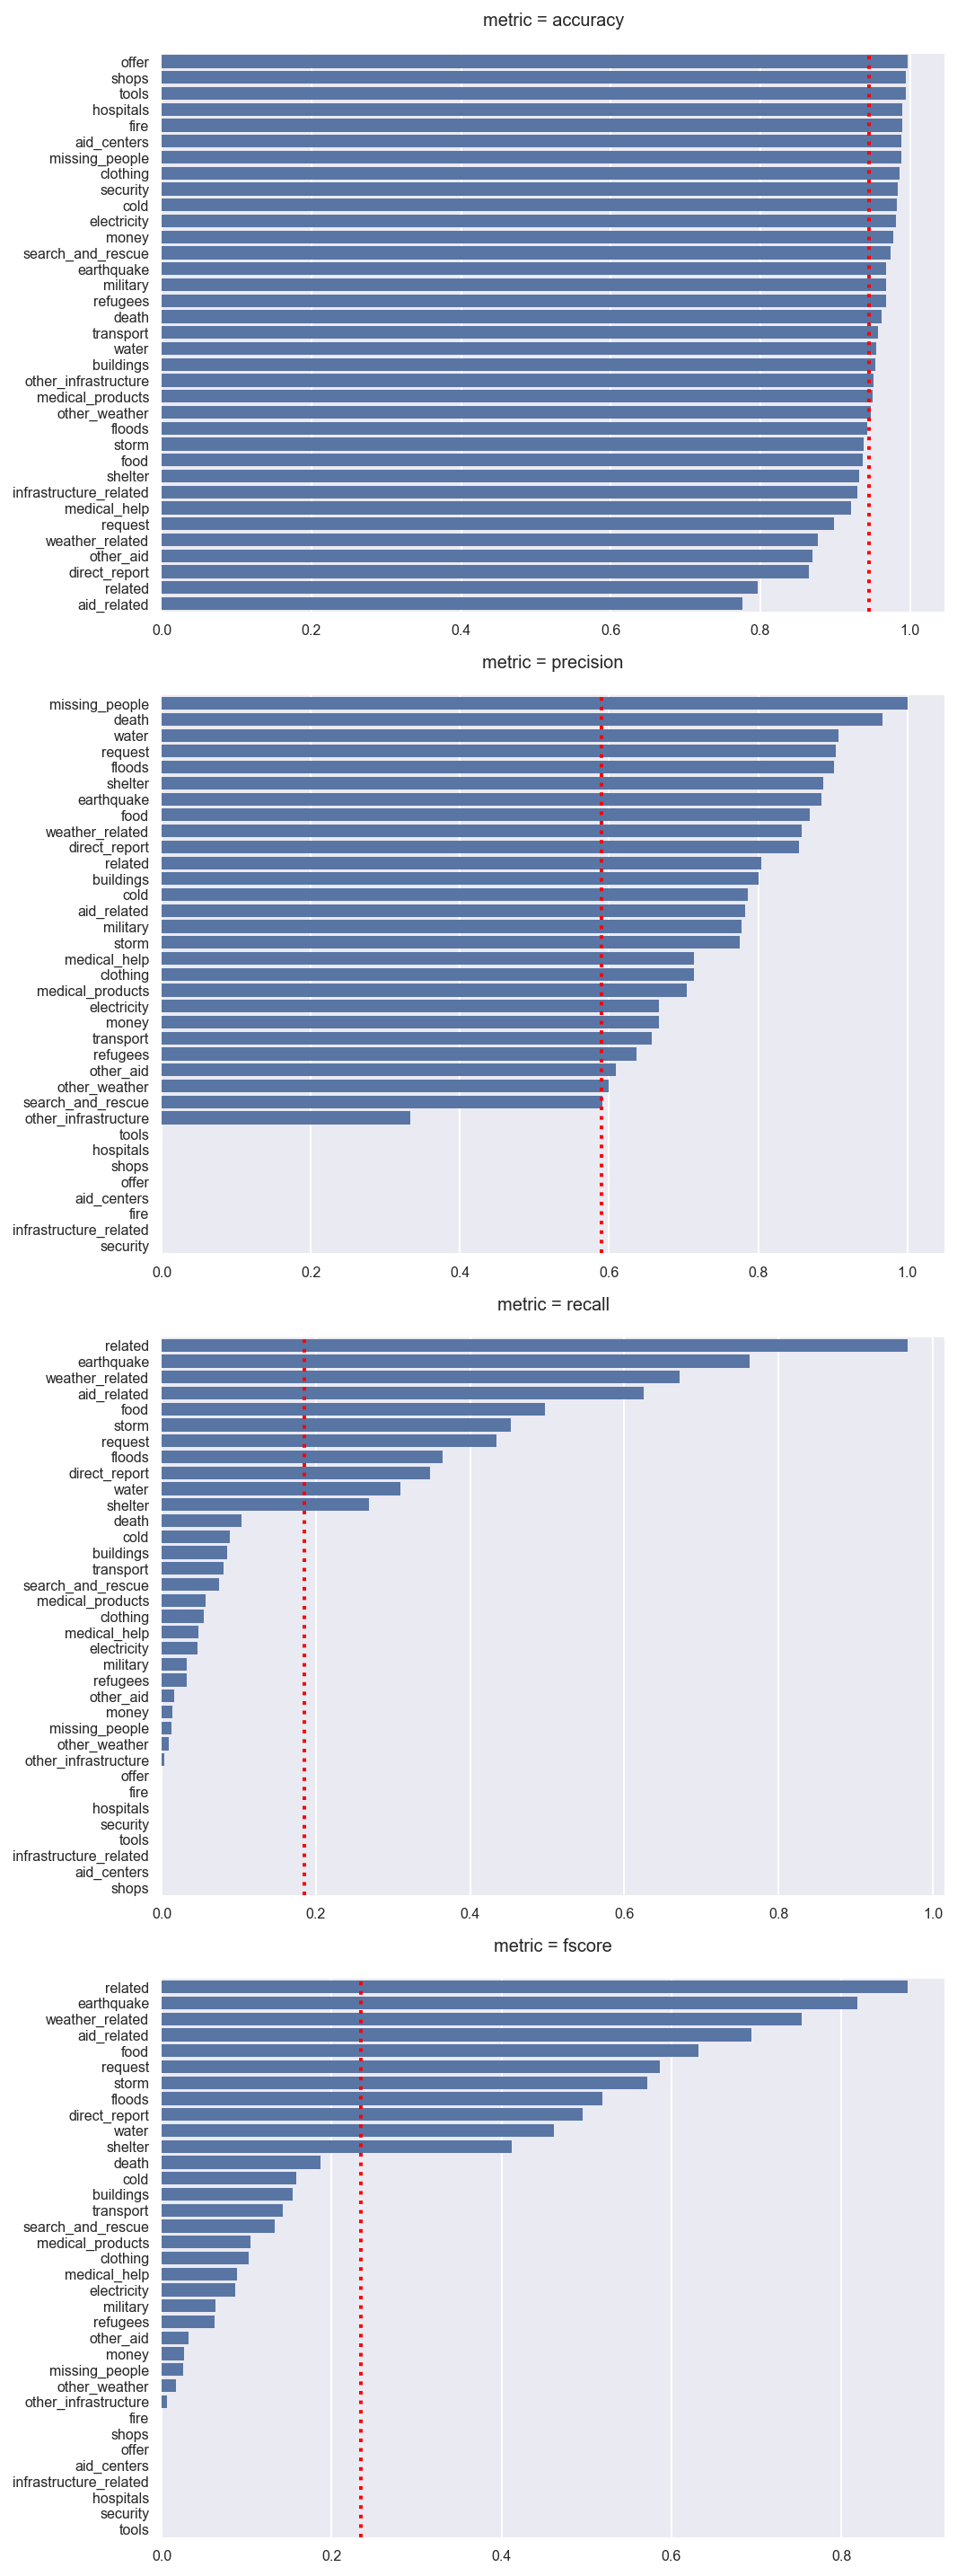

In [52]:
g = sns.FacetGrid(data=metric_complete_1.query('index==1'), row='metric', row_order=metric_order, sharex=False, sharey=False, height=5, aspect=1.5)

g.map_dataframe(sns.barplot, x='metric_value', y='label')

for ax, mean in zip(g.axes.flat, mean_values_1):
    ax.axvline(x=mean, color='r', linestyle=':')

    

#### Summary of first results

The results for accuracy are very good. Unfortunately, that says very little. If you look at the Precision metric, the quality of the prediction is considerably worse. In the case of metric recall, a measure of the completeness of the prediction, the model fails completely. The fscore metric is calculated from recall and precision and follows the recall metric.


### 6. Improve your model
Use grid search to find better parameters. 

In [53]:
pipeline_1.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x7f7ee80328b0>)),
  ('tfidf', TfidfTransformer()),
  ('clf', MultiOutputClassifier(estimator=RandomForestClassifier()))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x7f7ee80328b0>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=RandomForestClassifier()),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf_

In [56]:
scorer = make_scorer(recall_score, average='micro')


parameters = {
        'vect__max_features': (None, 5000, 10000),
        'tfidf__use_idf': (True, False),
        'clf__estimator__min_samples_split': [2,10, 20],
    }

cv_2 = GridSearchCV(pipeline_1, param_grid=parameters, scoring=scorer, n_jobs=7, verbose=10)



In [57]:
%%time
cv_2.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:  5.5min
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed: 10.5min
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed: 16.0min
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed: 20.8min
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed: 28.3min
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed: 33.5min
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed: 40.9min
[Parallel(n_jobs=7)]: Done  71 tasks      | elapsed: 48.5min
[Parallel(n_jobs=7)]: Done  87 out of  90 | elapsed: 56.3min remaining:  1.9min
[Parallel(n_jobs=7)]: Done  90 out of  90 | elapsed: 56.4min finished


CPU times: user 3min 3s, sys: 2.13 s, total: 3min 5s
Wall time: 59min 29s


GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x7f7ee80328b0>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier()))]),
             n_jobs=7,
             param_grid={'clf__estimator__min_samples_split': [2, 10, 20],
                         'tfidf__use_idf': (True, False),
                         'vect__max_features': (None, 5000, 10000)},
             scoring=make_scorer(recall_score, average=micro), verbose=10)

In [58]:
cv_2.best_params_

{'clf__estimator__min_samples_split': 10,
 'tfidf__use_idf': True,
 'vect__max_features': 5000}

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [59]:
%%time
y_pred_2 = pd.DataFrame((cv_2.predict(X_test)), columns=y_test.columns)

CPU times: user 11 s, sys: 136 ms, total: 11.2 s
Wall time: 11.2 s


In [60]:
metric_complete_2 = create_metric_dataframe(y_test, y_pred_2, labels)

In [61]:
metric_means_2, mean_values_2 = create_metric_mean(metric_complete_2, 1, metric_order)

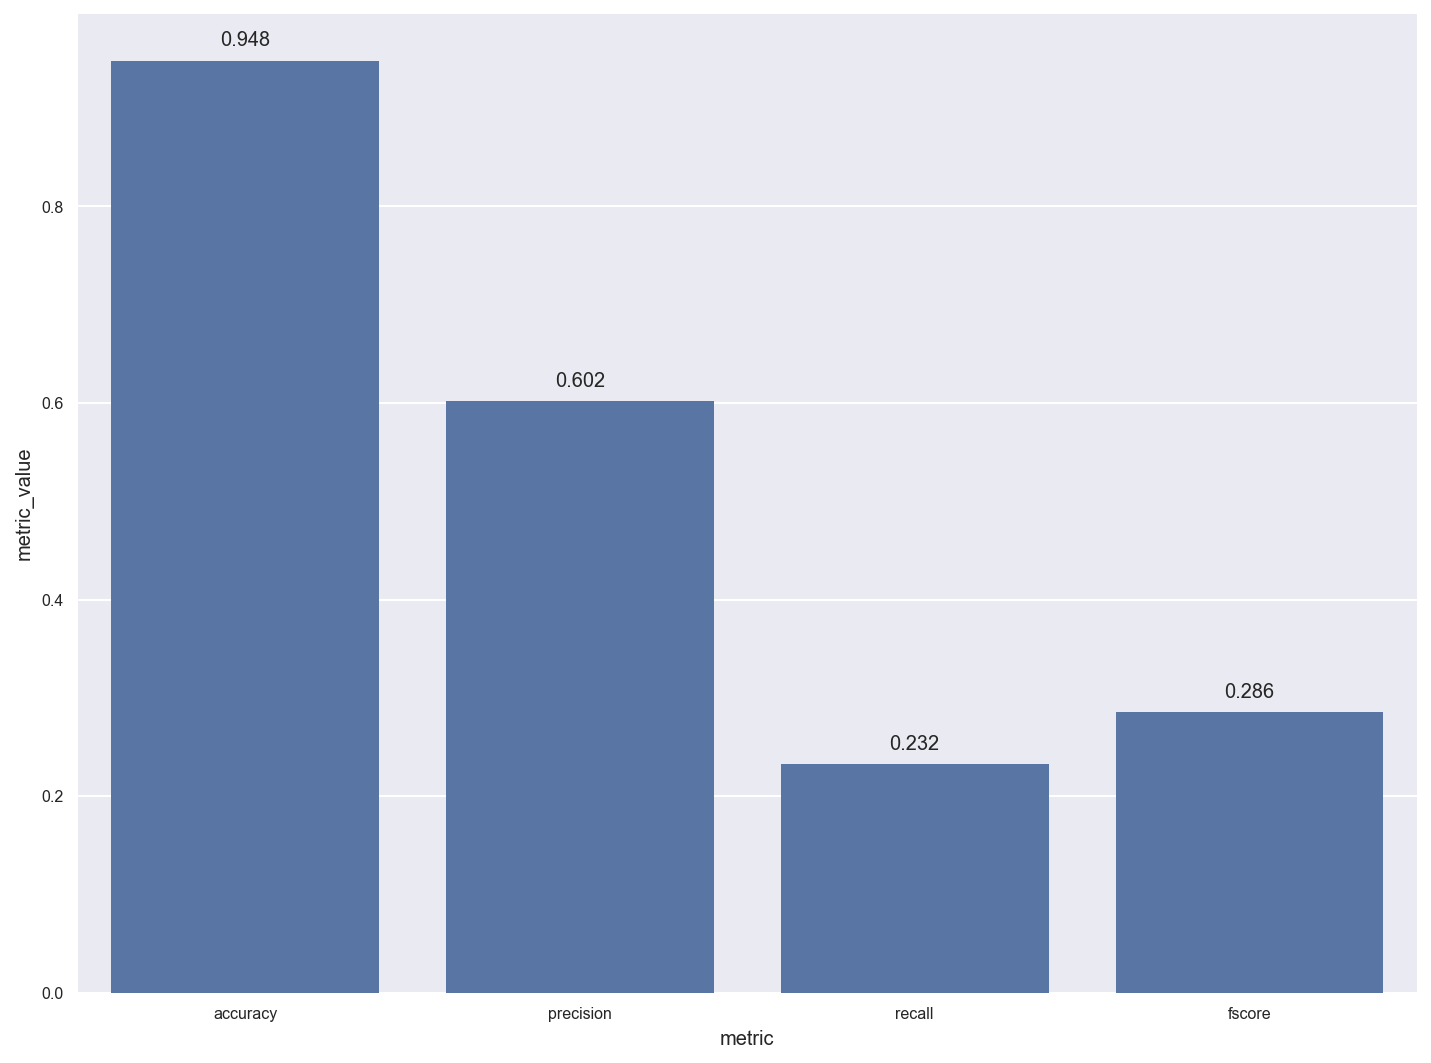

In [62]:
ax = sns.barplot(data=metric_means_2.reset_index(), x='metric', y='metric_value', order=metric_order, color=blue)

for p in ax.patches:
    text = '{}'.format(round(p.get_height(),3))
    xy = (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height())
    ax.annotate(text, xy, ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')



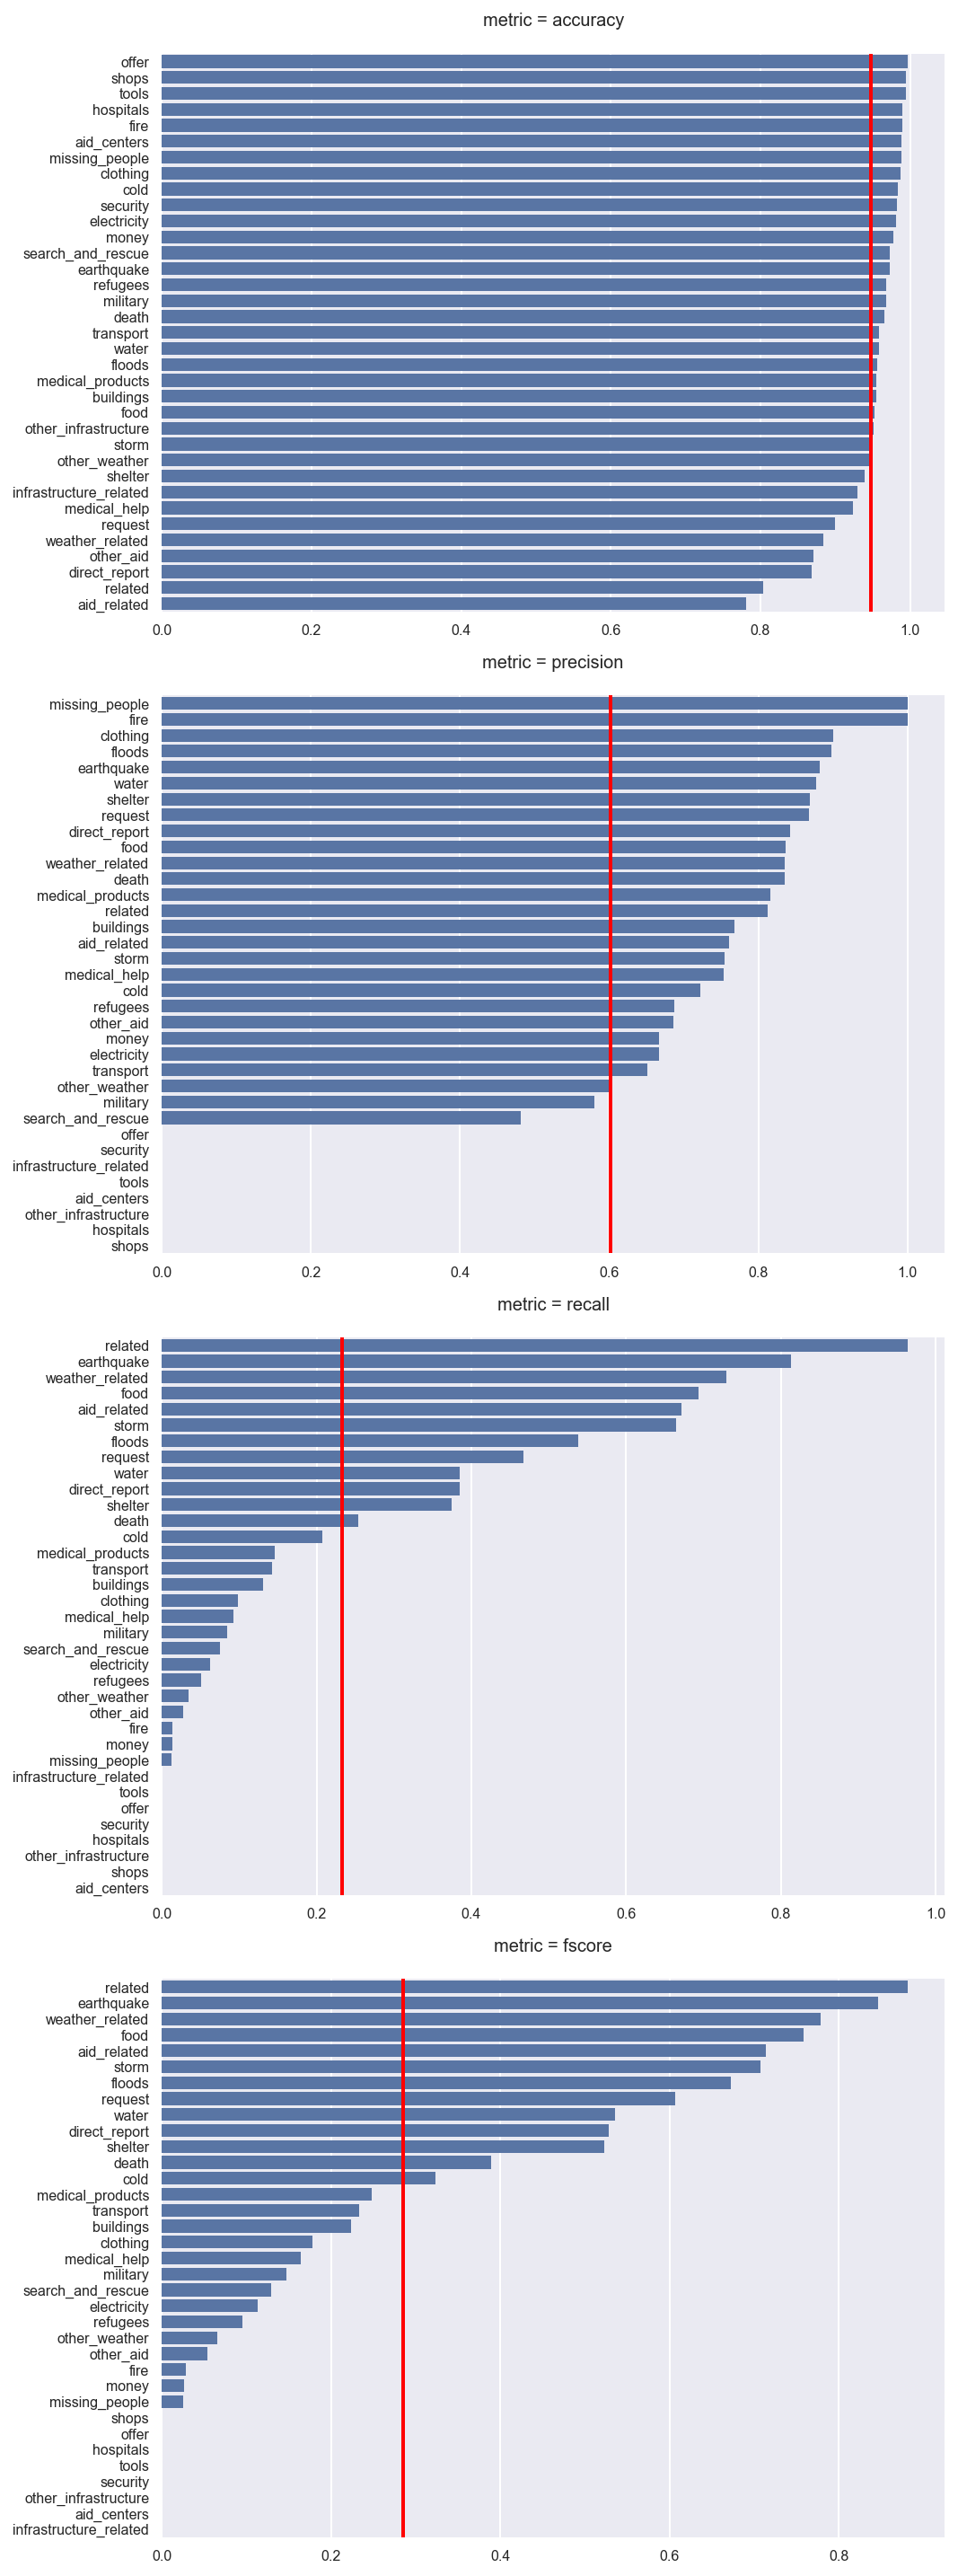

In [63]:
g = sns.FacetGrid(data=metric_complete_2.query('index==1'), row='metric', row_order=metric_order, sharex=False, sharey=False, height=5, aspect=1.5)

g.map_dataframe(sns.barplot, x='metric_value', y='label')

for ax, mean in zip(g.axes.flat, mean_values_2):
    ax.axvline(x=mean, color='r', linestyle='-')


#### Summary GridSearchCV

The use of GridSearchCV could improve the recall metric by almost 5%. However, it is still very bad at 22%.<br>
I propose to use a different classifier.

### 8. Try improving your model further. Here are a few ideas:
* I will use the DecissionTreeClassifier
* I will add the text length as feature
* The tokenize function gets an update to remove stopwords

#### Update tokenize to remove stopwords

In [95]:
stop_words = stopwords.words("english")


In [96]:
def tokenize(text):
    # Step 1 Normalisation
    text = re.sub(r'[^A-Za-z0-9]', ' ', text.lower())
    
    # Step 2 Tokenzation
    words = word_tokenize(text)
    
    #Step 3 Remove stopwords
    words = [w for w in words if w not in stop_words]
    
    #Step 4 Lemmatization
    tokens = [WordNetLemmatizer().lemmatize(word=w) for w in words]
    
    return tokens

#### Textlength Extactor


In [97]:
class TextlengthExtractor(BaseEstimator, TransformerMixin):

    def extract_text_length(self, text):
        length_text = len(text)
        return length_text

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.extract_text_length)
        return pd.DataFrame(X_tagged)


#### Create Pipeline

In [98]:
pipeline_3 = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('text_length', TextlengthExtractor())
            
        ])),

        ('clf', MultiOutputClassifier(DecisionTreeClassifier()))
    ])

In [99]:
%%time
pipeline_3.fit(X_train, y_train)

CPU times: user 2min 36s, sys: 224 ms, total: 2min 36s
Wall time: 2min 36s


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenize at 0x7f7886371310>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('text_length',
                                                 TextlengthExtractor())])),
                ('clf',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier()))])

In [100]:
%%time
y_pred_3 = pd.DataFrame(pipeline_3.predict(X_test), columns=labels)


CPU times: user 1.52 s, sys: 3.92 ms, total: 1.53 s
Wall time: 1.52 s


In [101]:
metric_complete_3 = create_metric_dataframe(y_test, y_pred_3, labels)


In [102]:
metric_means_3, mean_values_3 = create_metric_mean(metric_complete_3, 1, metric_order)

In [146]:
metric_means_3

,metric_value
metric,
accuracy,0.930599
precision,0.407692
recall,0.379403
fscore,0.391689


In [151]:
metric_mean = metric_complete_3.groupby(['metric', 'index']).mean().reset_index().query('index==1')

metric_mean

,metric,index,metric_value
1,accuracy,1,0.930599
3,fscore,1,0.391689
5,precision,1,0.407692
7,recall,1,0.379403


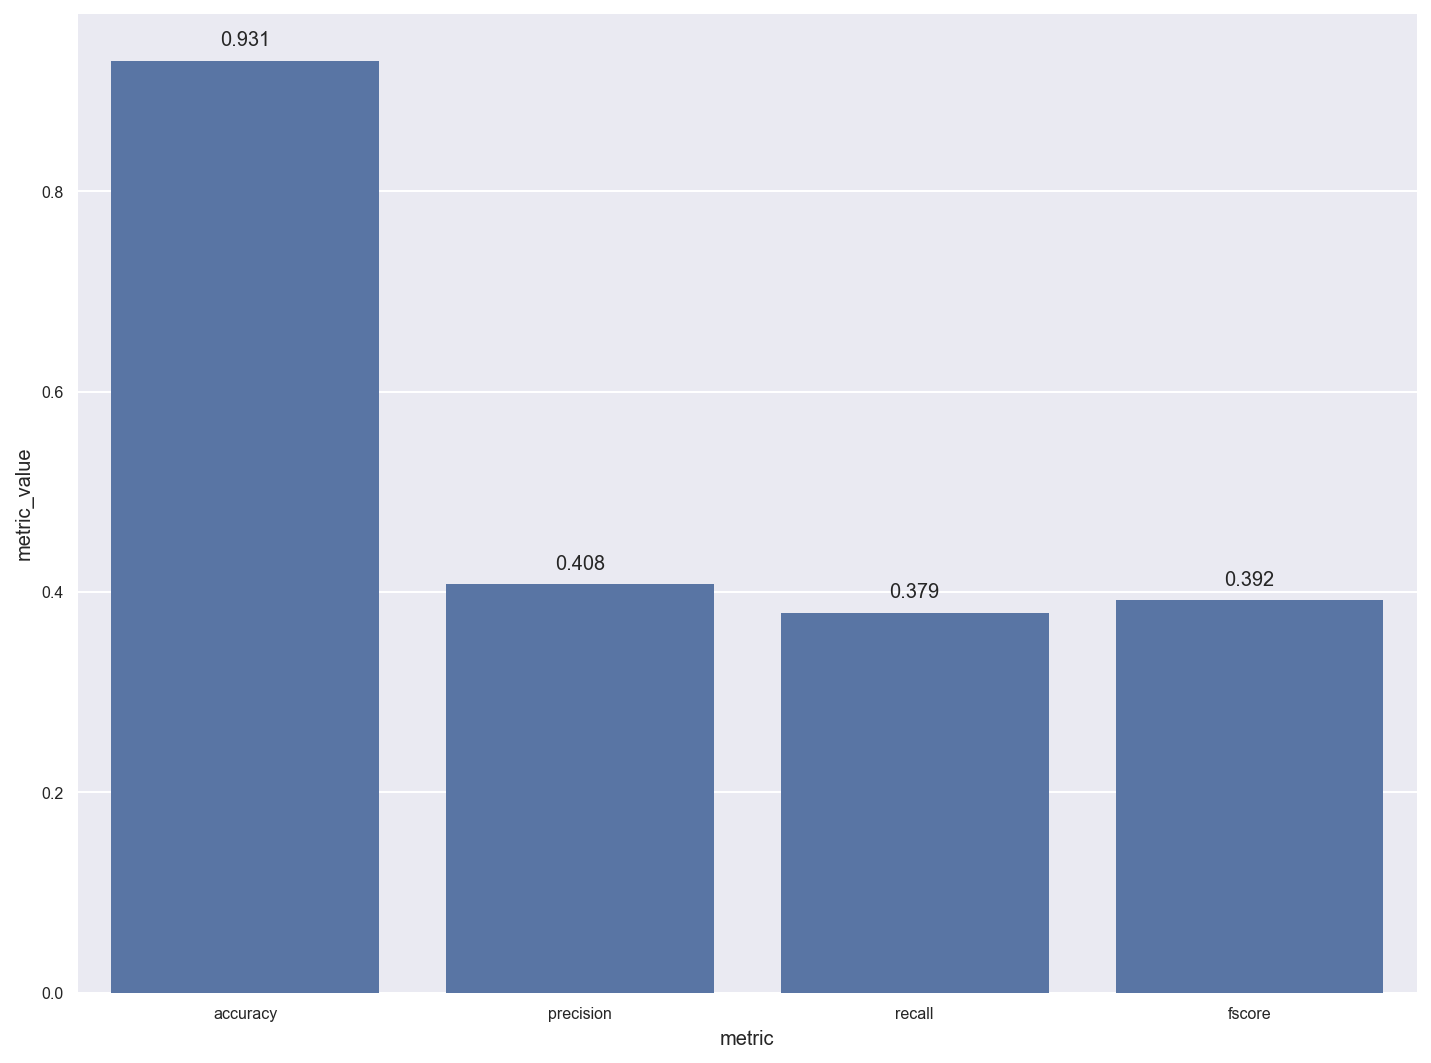

In [105]:
ax = sns.barplot(data=metric_means_3.reset_index(), x='metric', y='metric_value', order=metric_order, color=blue)

for p in ax.patches:
    text = '{}'.format(round(p.get_height(),3))
    xy = (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height())
    ax.annotate(text, xy, ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')




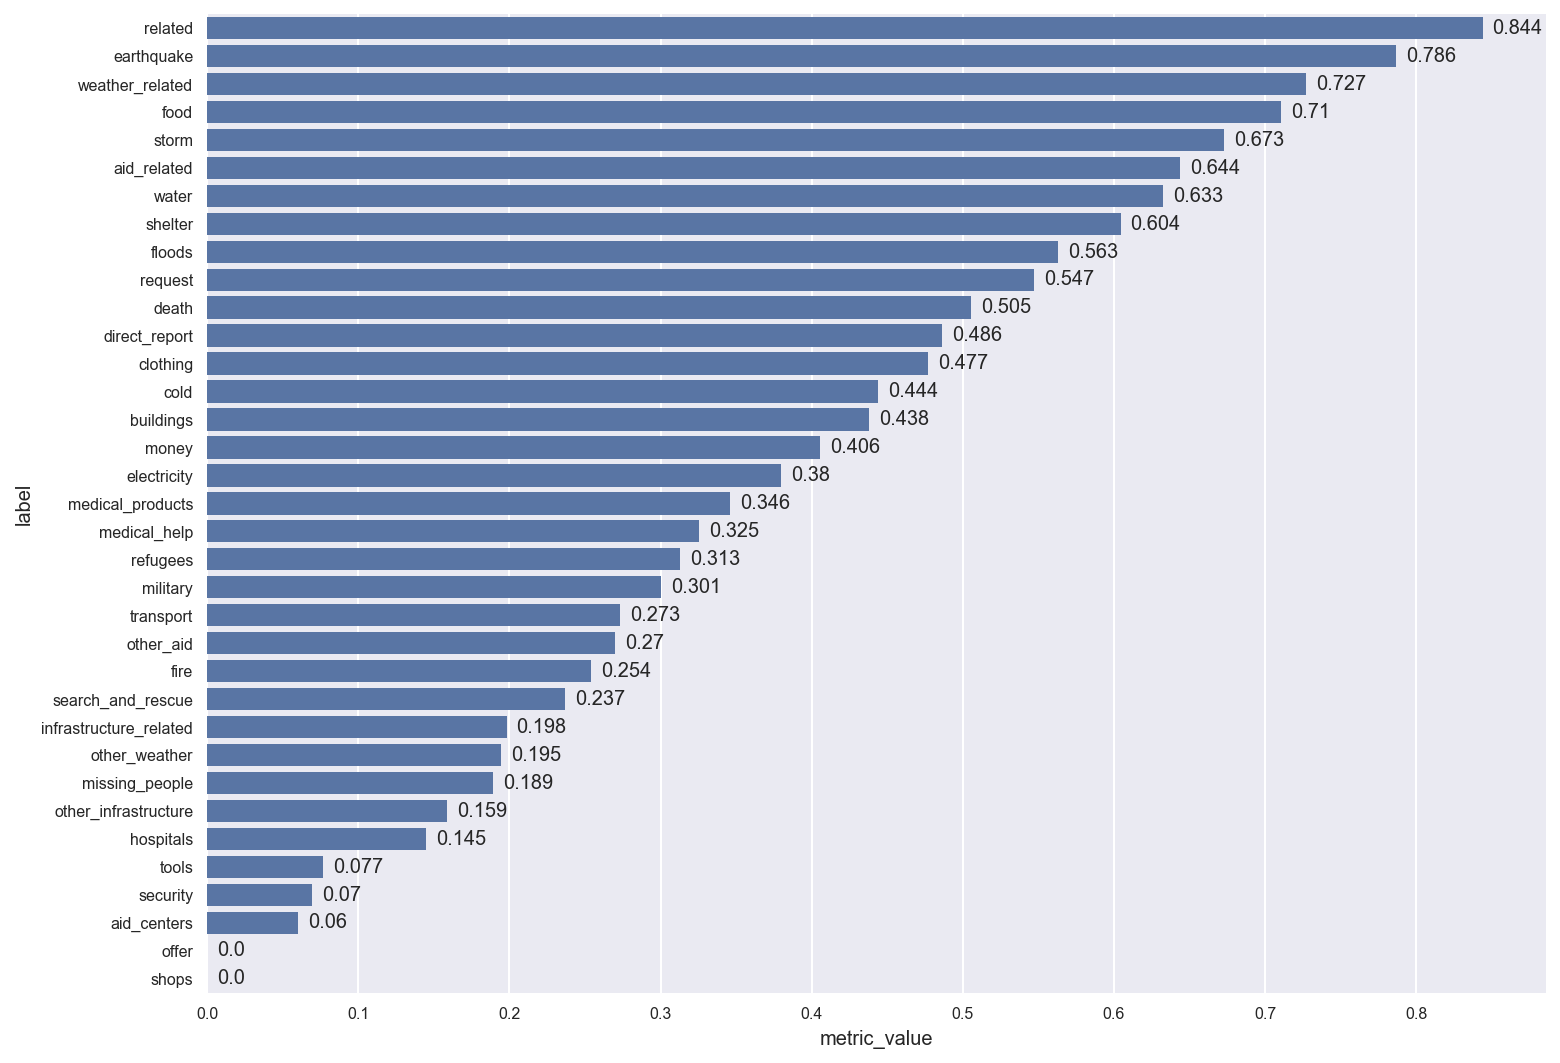

In [134]:
ax = sns.barplot(data=metric_complete_3.query('index==1 and metric=="recall"'), x='metric_value', y='label', color=blue)

for p in ax.patches:
    text = '{}'.format(round(p.get_width(),3))
    xy = (p.get_width(), p.get_y() + p.get_height() / 2)
    ax.annotate(text, xy, ha = 'left', va = 'center', xytext = (5, 0), textcoords = 'offset points')



In [143]:
metric_complete_3.to_csv('../data/metric_complete.csv', index=False)

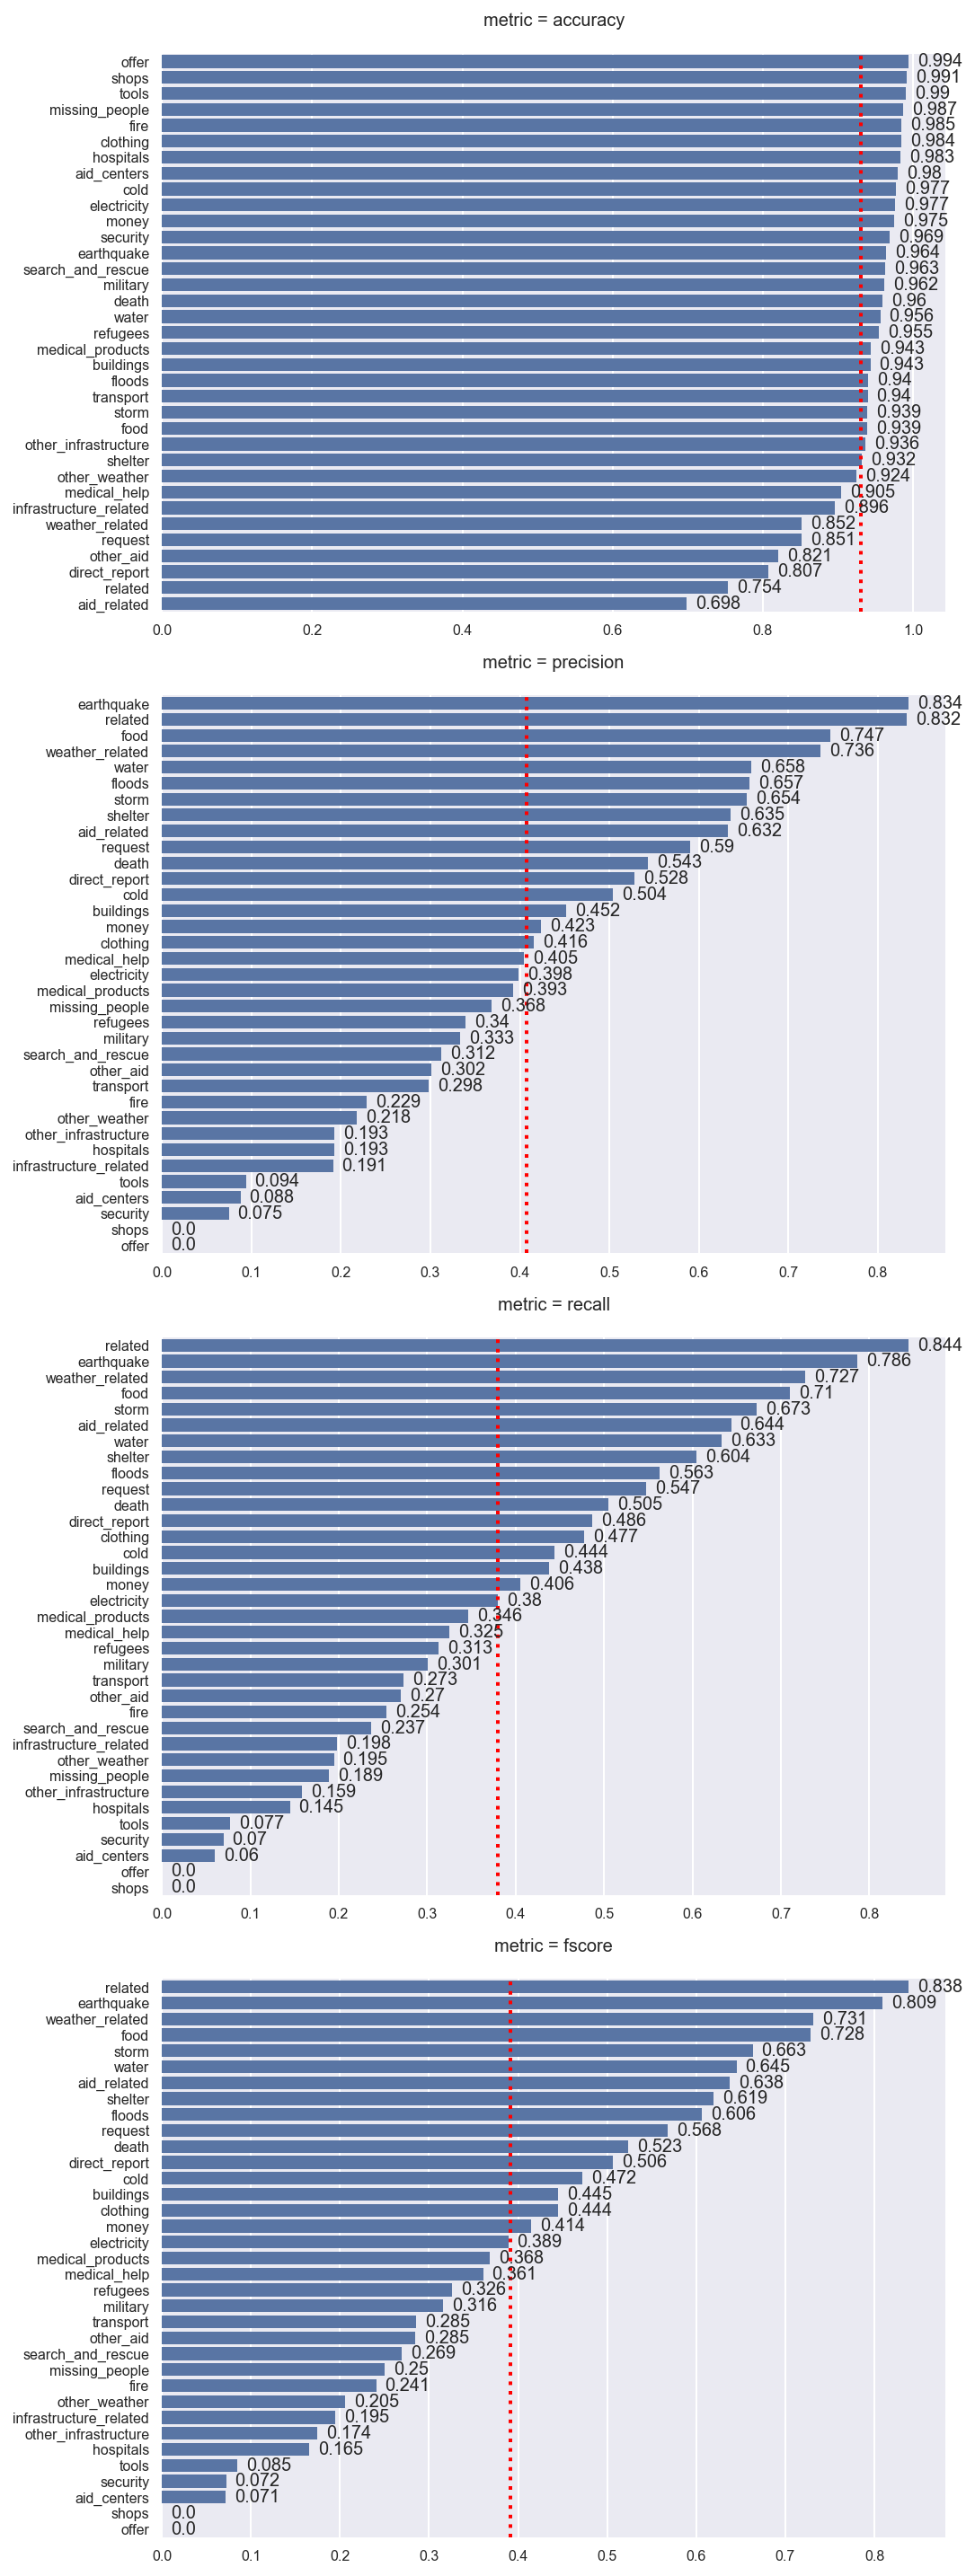

In [136]:

g = sns.FacetGrid(data=metric_complete_3.query('index==1'), row='metric', row_order=metric_order, sharex=False, sharey=False, height=5, aspect=1.5)

g.map_dataframe(sns.barplot, x='metric_value', y='label')

for ax, mean in zip(g.axes.flat, mean_values_3):

    for p in ax.patches:
        text = '{}'.format(round(p.get_width(),3))
        xy = (p.get_width(), p.get_y() + p.get_height() / 2)
        ax.annotate(text, xy, ha = 'left', va = 'center', xytext = (5, 0), textcoords = 'offset points')


    ax.axvline(x=mean, color='r', linestyle=':')


In [137]:
category_count = y.sum().reset_index()
category_count.columns = ['category', 'count']
category_count = category_count.sort_values(by='count', ascending=False)


In [139]:
category_count['ratio'] = category_count['count']/df.shape[0]

category_count.head()


,category,count,ratio
0,related,19906,0.759307
3,aid_related,10860,0.414251
27,weather_related,7297,0.278341
34,direct_report,5075,0.193584
1,request,4474,0.170659


<AxesSubplot:xlabel='count', ylabel='category'>

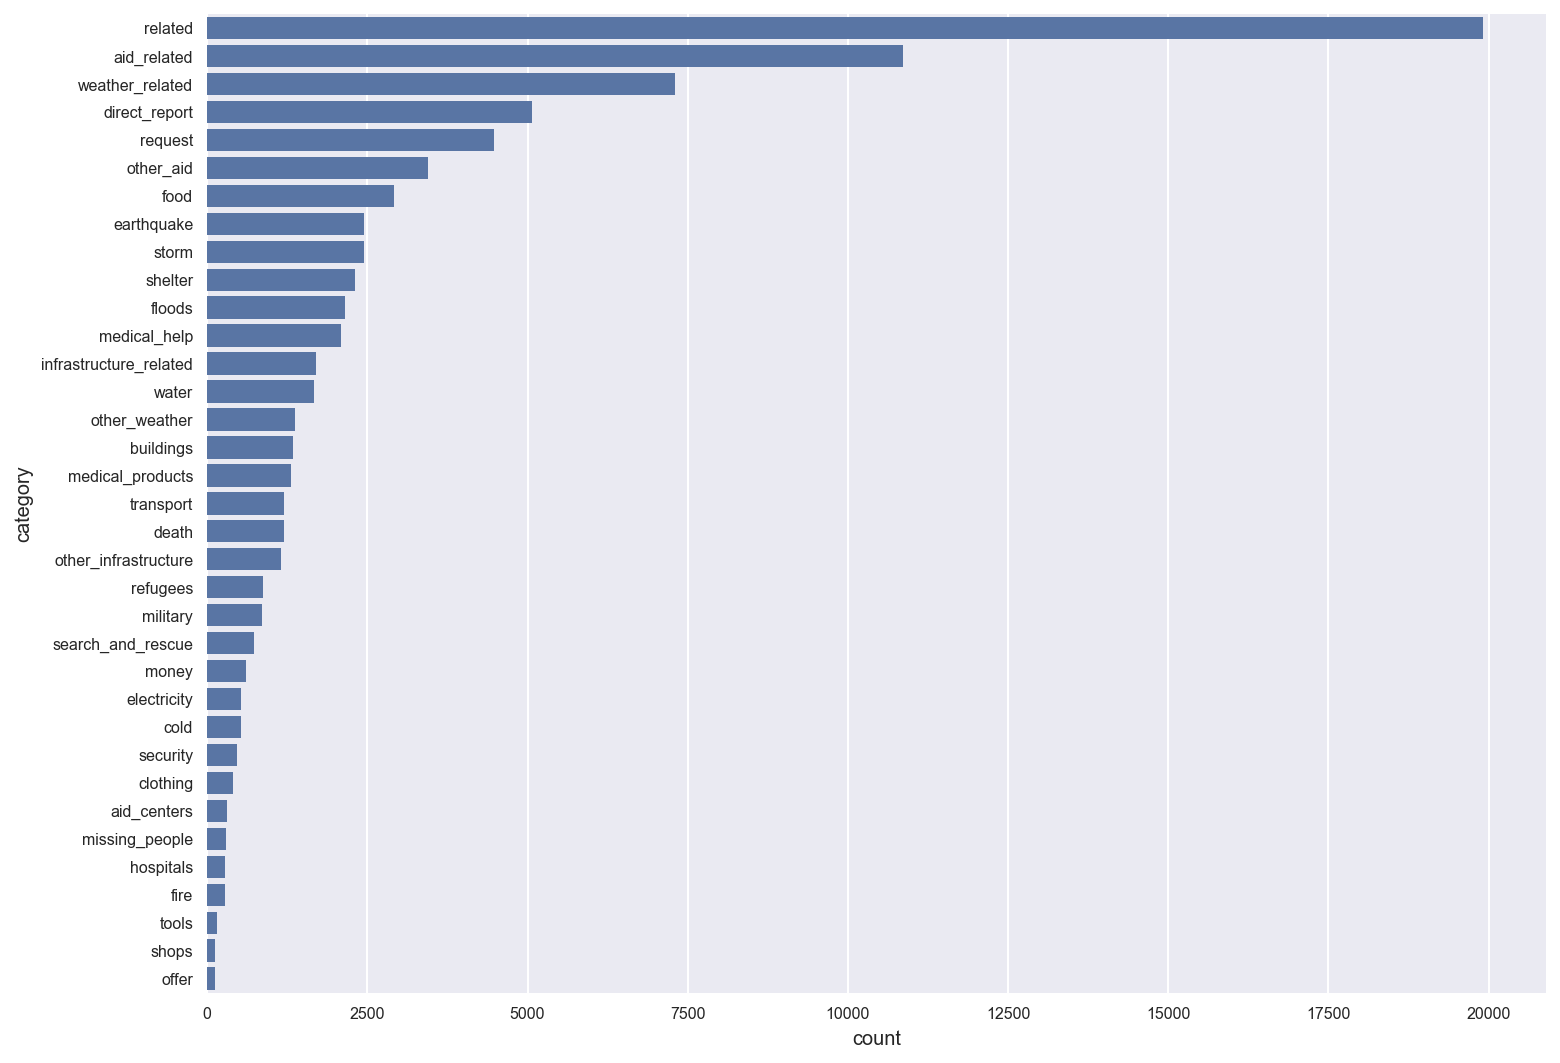

In [141]:
sns.barplot(data=category_count, x='count', y='category', color=blue)

In [53]:
recall_3 = metric_complete_3.query('metric == "recall" and index == 1')[['label', 'metric_value']]
category_count_recall = category_count.merge(recall_3, left_on='category', right_on='label').melt(id_vars=['category', 'count', 'label']).sort_values(by='value', ascending=False)


In [74]:
category_order = category_count.reset_index().drop('index', axis=1)
recall_order = recall_3.reset_index().drop('index', axis=1)

recall_order.query('label == "food"').index[0]

3

In [76]:
categories = []
performance = []
for i in category_order.index:
    category = category_order.iloc[i, 0]
    idx = recall_order.query('label==@category').index[0]
    categories.append(category)
    performance.append(i-idx)


    

In [79]:
performance = pd.DataFrame({'category': categories, 'performance':performance}).sort_values(by='performance')
performance.head()

,category,performance
5,other_aid,-18
12,infrastructure_related,-16
19,other_infrastructure,-10
14,other_weather,-10
3,direct_report,-9


<AxesSubplot:xlabel='performance', ylabel='category'>

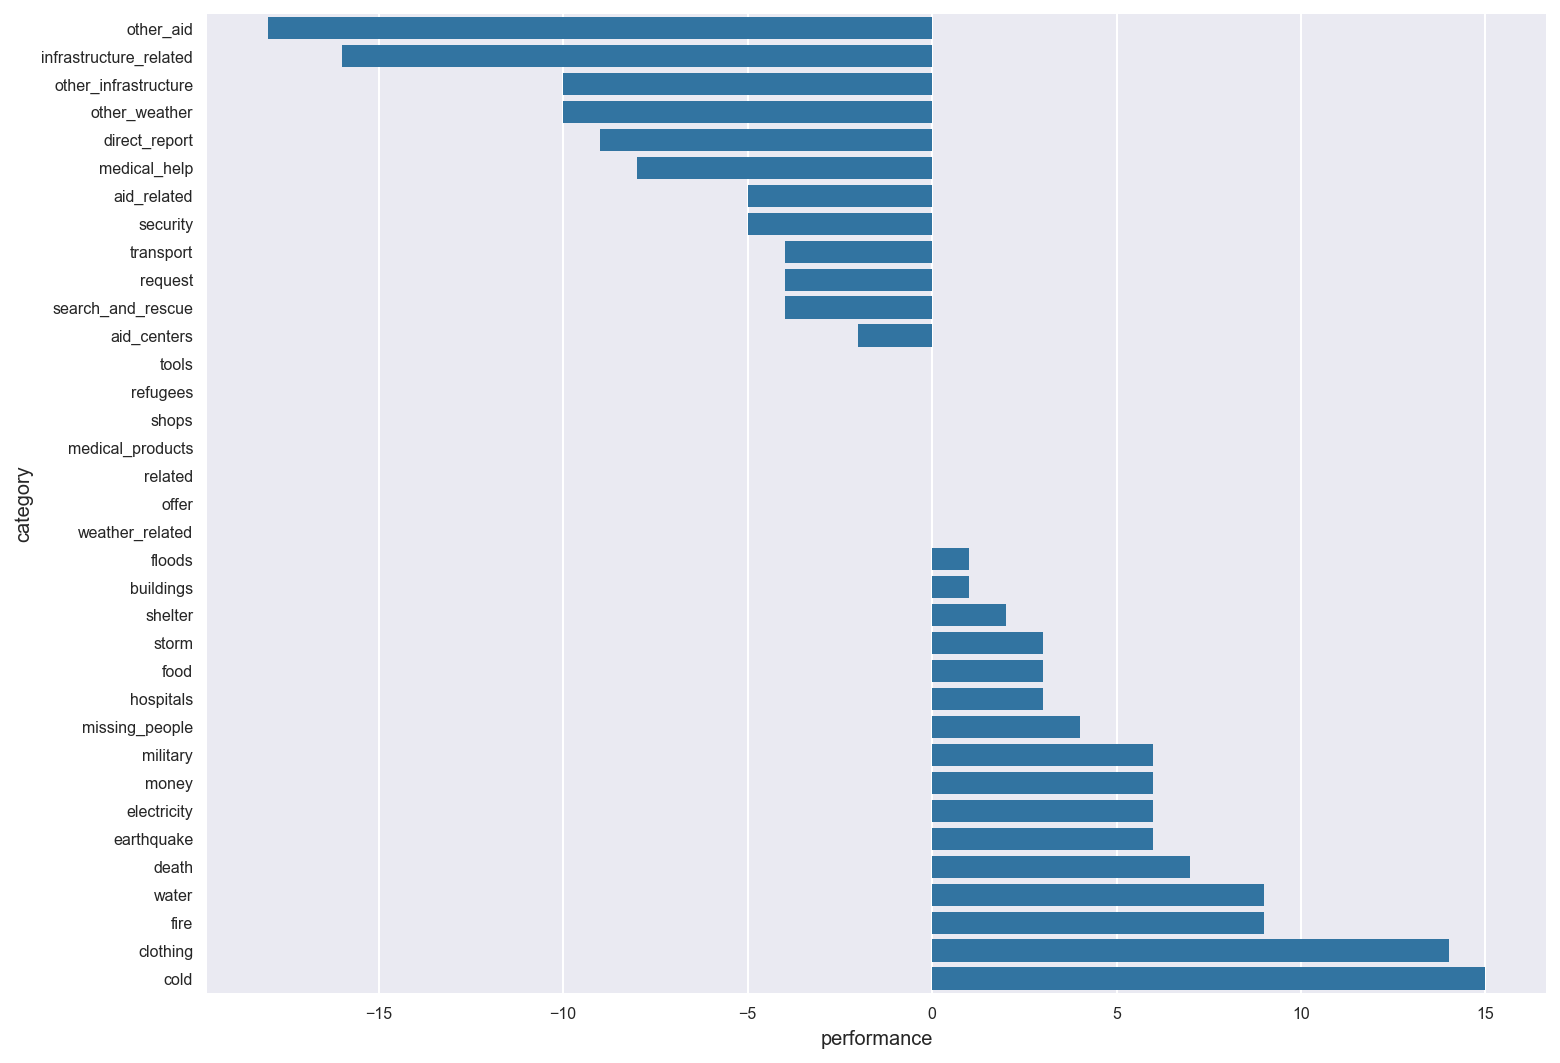

In [81]:
sns.barplot(data=performance, x='performance', y='category', color=blue)

In [145]:
performance.to_csv('../data/performance.csv', index=False)

<AxesSubplot:xlabel='value', ylabel='category'>

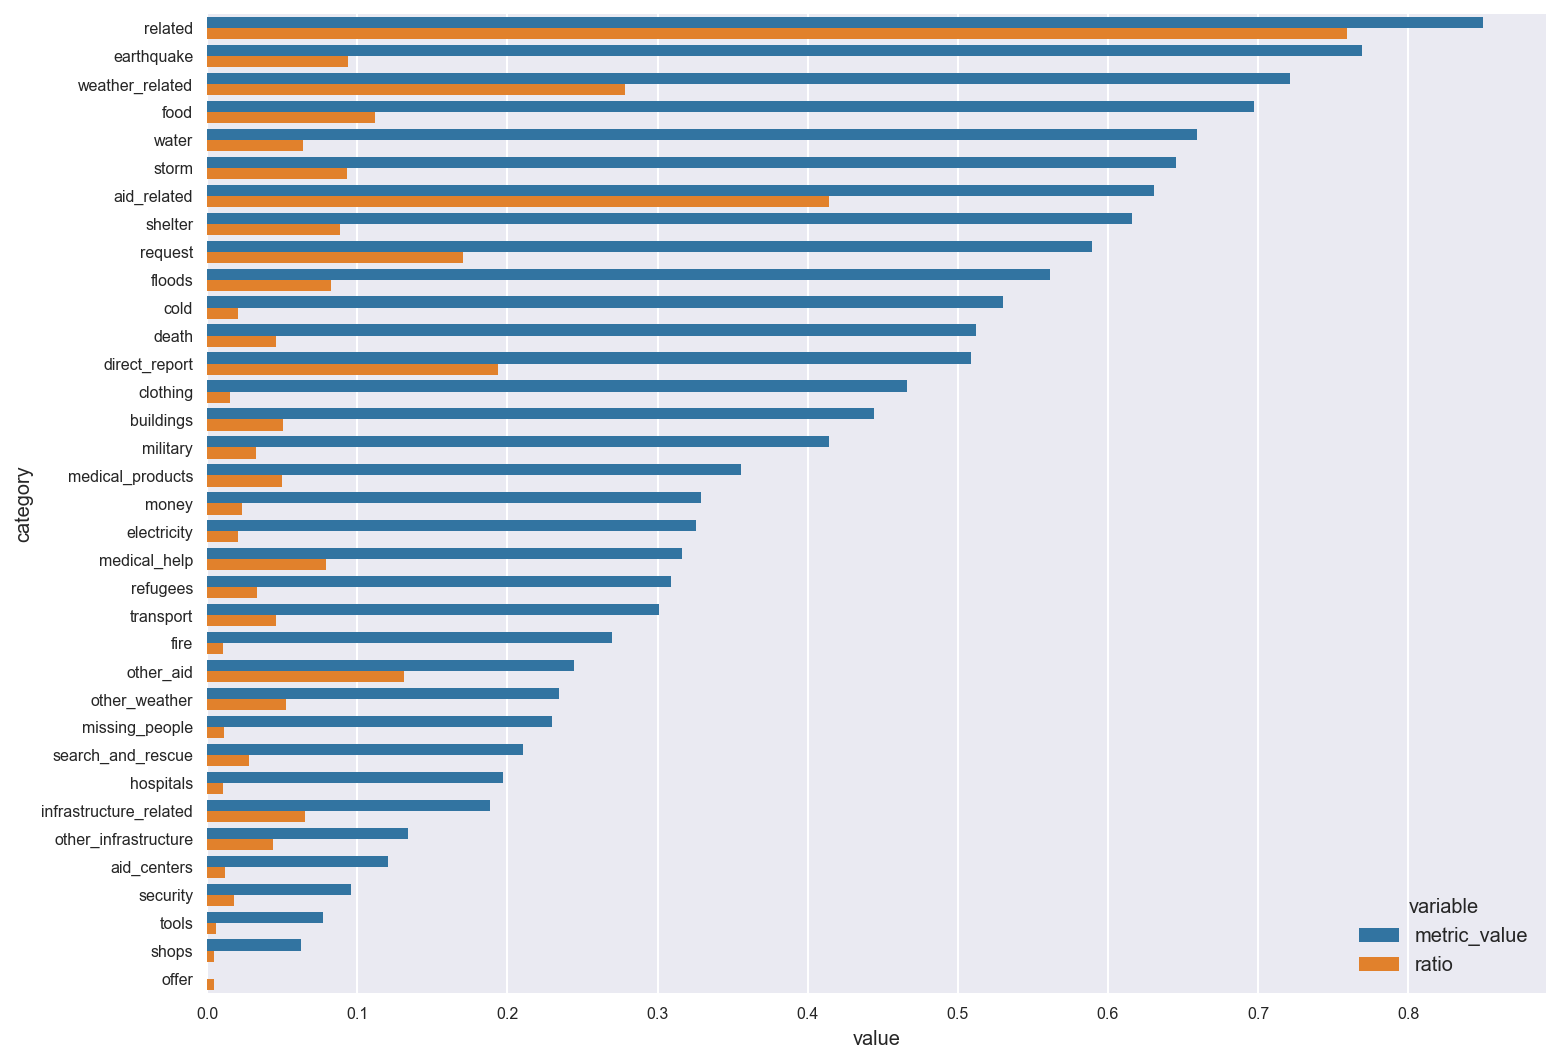

In [55]:
palette = {
    'metric_value': 'tab:blue',
    'ratio': 'tab:orange',
}

sns.barplot(data=category_count_recall, x='value', y='category', hue='variable', palette=palette)

In [113]:
pipeline_3

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenize at 0x7f7e8d914ee0>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('text_length',
                                                 TextlengthExtractor())])),
                ('clf',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier()))])

In [114]:
parameters = {
        'features__text_pipeline__vect__max_features': (None, 5000, 10000),
        'features__text_pipeline__vect__min_df': [1, 5],
        'features__text_pipeline__tfidf__use_idf':[True, False],
        'clf__estimator__criterion': ['gini', 'entropy'],
        'clf__estimator__min_samples_split': [2,10],
        
    }

cv_4 = GridSearchCV(pipeline_3, param_grid=parameters, n_jobs=7, scoring=scorer, verbose=11)



In [115]:
%%time
cv_4.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:  2.1min
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:  2.9min
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:  3.0min
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:  3.0min
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:  3.0min
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:  3.1min
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:  4.2min
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:  4.4min
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:  5.1min
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:  5.1min
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:  5.2min
[Parallel(n_jobs=7)]: Done  13 tasks      | elapsed:  5.2min
[Parallel(n_jobs=7)]: Done  14 tasks      | elapsed:  5.3min
[Parallel(n_jobs=7)]: Done  15 tasks      | elapsed:  6.4min
[Parallel(

CPU times: user 2min 34s, sys: 1.82 s, total: 2min 36s
Wall time: 1h 6min 37s


GridSearchCV(estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('text_pipeline',
                                                                        Pipeline(steps=[('vect',
                                                                                         CountVectorizer(tokenizer=<function tokenize at 0x7f7e8d914ee0>)),
                                                                                        ('tfidf',
                                                                                         TfidfTransformer())])),
                                                                       ('text_length',
                                                                        TextlengthExtractor())])),
                                       ('clf',
                                        MultiOutputClassifier(estimator=DecisionTreeClassifier()))]),
             n_jobs=7,
             param_grid={'clf__estima

In [116]:
cv_4.best_params_

{'clf__estimator__criterion': 'gini',
 'clf__estimator__min_samples_split': 2,
 'features__text_pipeline__tfidf__use_idf': True,
 'features__text_pipeline__vect__max_features': None,
 'features__text_pipeline__vect__min_df': 1}

In [117]:
%%time
y_pred_4 = pd.DataFrame(cv_4.predict(X_test), columns=labels)


CPU times: user 1.54 s, sys: 45.4 ms, total: 1.59 s
Wall time: 1.59 s


In [118]:
metric_complete_4 = create_metric_dataframe(y_test, y_pred_4, labels)

In [119]:
metric_means_4, mean_values_4 = create_metric_mean(metric_complete_4, 1, metric_order)

In [120]:
mean_values_4

array([0.92969615, 0.40239966, 0.3846569 , 0.39271424])

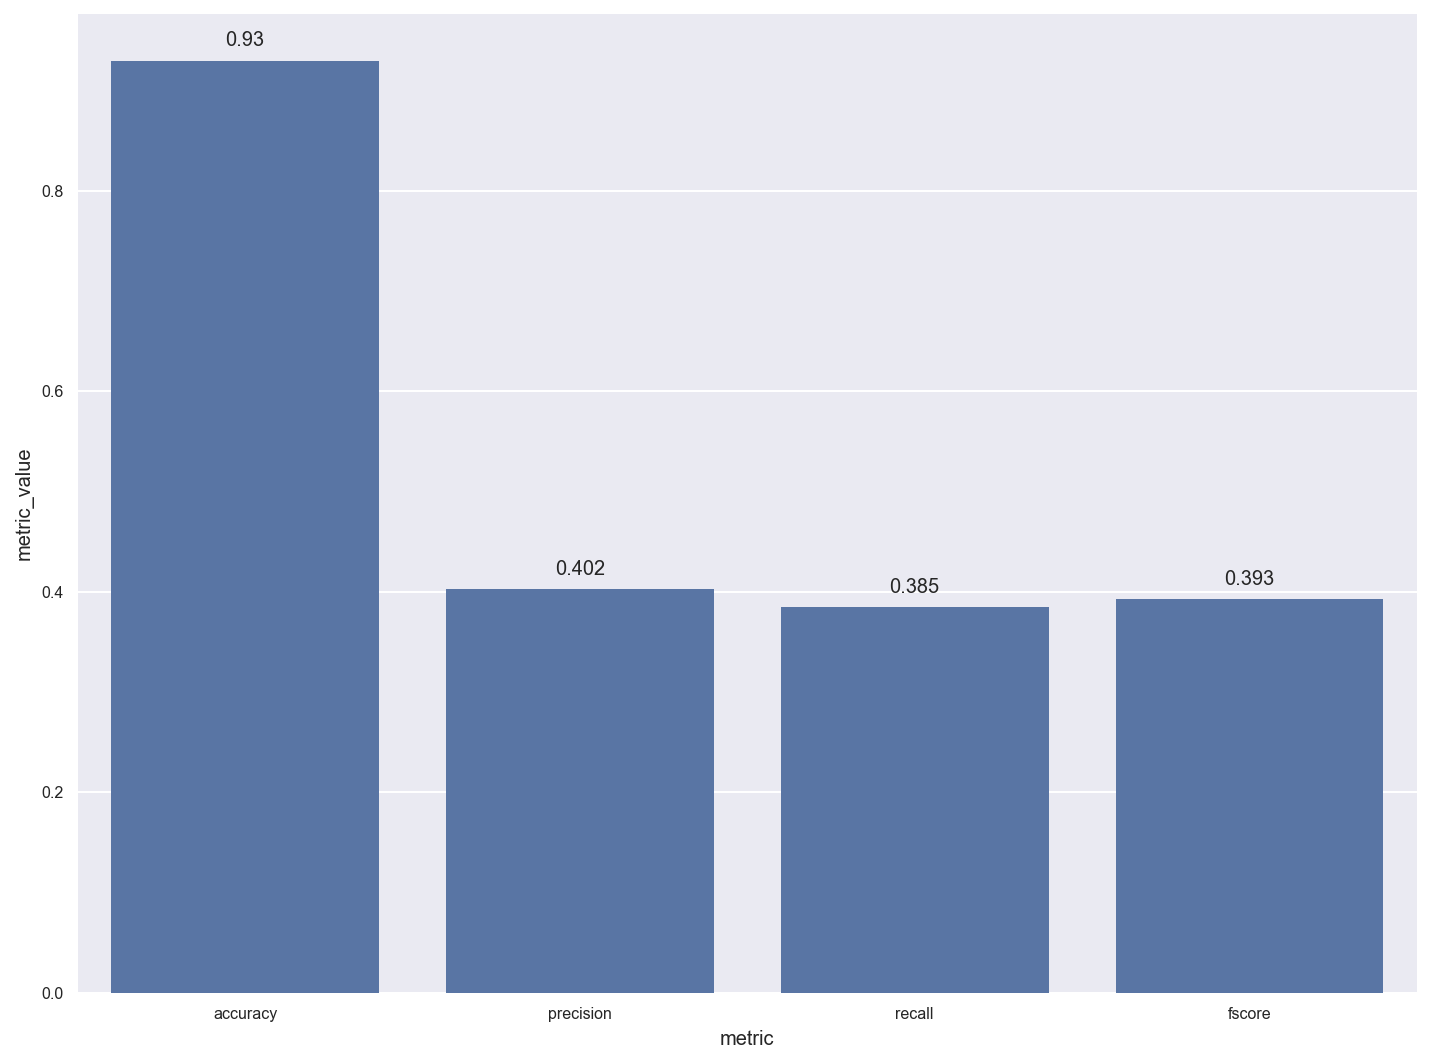

In [122]:
ax = sns.barplot(data=metric_means_4.reset_index(), x='metric', y='metric_value', order=metric_order, color=blue)

for p in ax.patches:
    text = '{}'.format(round(p.get_height(),3))
    xy = (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height())
    ax.annotate(text, xy, ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')



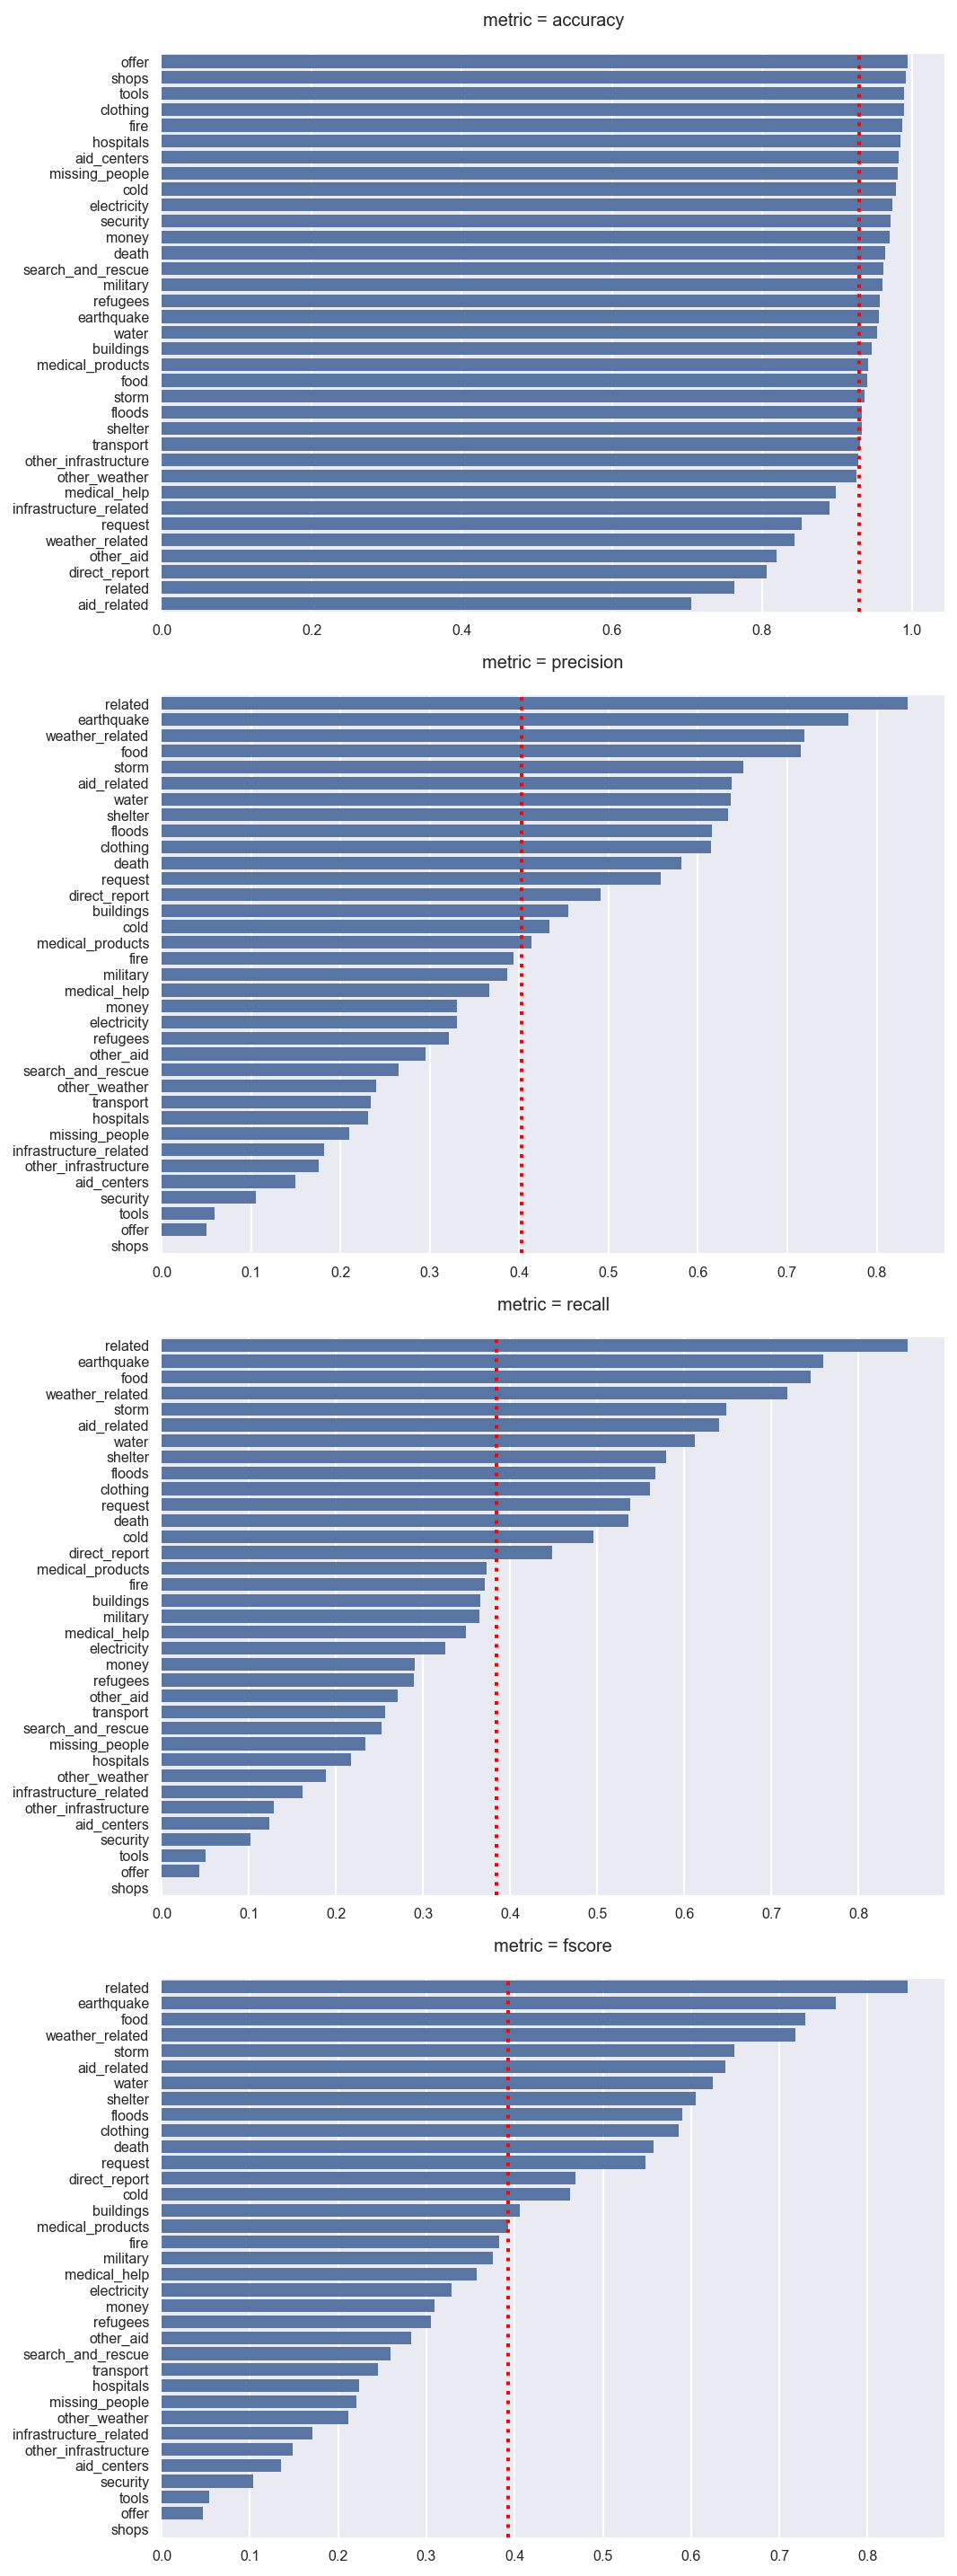

In [123]:
g = sns.FacetGrid(data=metric_complete_4.query('index==1'), row='metric', row_order=metric_order, sharex=False, sharey=False, height=5, aspect=1.5)

g.map_dataframe(sns.barplot, x='metric_value', y='label')

for ax, mean in zip(g.axes.flat, mean_values_4):
    ax.axvline(x=mean, color='r', linestyle=':')


### 9. Export your model as a pickle file

The best model is the cv_3. This will be used for the web app.

In [133]:
cv_4.best_estimator_

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenize at 0x7f7e8d914ee0>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('text_length',
                                                 TextlengthExtractor())])),
                ('clf',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier()))])

In [134]:
pipeline_3

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenize at 0x7f7e8d914ee0>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('text_length',
                                                 TextlengthExtractor())])),
                ('clf',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier()))])

In [135]:
import joblib
joblib.dump(pipeline_3, 'DecisionTree.pkl', compress=1)


['DecisionTree.pkl']

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.